<a href="https://colab.research.google.com/github/lubanabdis/skripsi-arsip/blob/main/source-code/Luban_10Fold_90_10_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Luban_10Fold_90:10/Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#IMPORT LIBRARY

In [ ]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Input
from tensorflow.keras.layers import  MaxPooling2D, Dense, Dropout, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, Add, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, Activation
from tensorflow.keras.activations import relu, softmax, swish, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision,SensitivityAtSpecificity, SpecificityAtSensitivity, Metric, TruePositives,FalseNegatives, Recall
from tensorflow.keras.models import load_model
from keras.models import load_model
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import files
from keras.applications.vgg19 import preprocess_input
from sklearn.utils import shuffle, resample
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping, ModelCheckpoint,CSVLogger, ReduceLROnPlateau, LearningRateScheduler
import datetime
from sklearn.metrics import accuracy_score, classification_report
from keras import backend as K
import random
from sklearn.model_selection import train_test_split,  StratifiedShuffleSplit
!pip install pycm==3.1
%load_ext tensorboard
from pycm import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#LABELLING

In [ ]:
df = None
for label in os.listdir(data_dir):
  data = []
  for img_filename in os.listdir(data_dir + '/' + label):
    filename, ext = os.path.splitext(img_filename)
    label_folder = os.path.join(data_dir, label)
    src_img_filepath = os.path.join(label_folder, img_filename)
    data.append(src_img_filepath)
  new_df = pd.DataFrame(data, columns=['path',])
  new_df['label'] = label
  df = pd.concat([df, new_df])
df

,path,label
0,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Monkeypox
1,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Monkeypox
2,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Monkeypox
3,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Monkeypox
4,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Monkeypox
...,...,...
245,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Measles
246,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Measles
247,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Measles
248,/content/drive/MyDrive/Luban_10Fold_90:10/Data...,Measles


#SPLIT DATASET FOR CV

In [ ]:
df_train_val, df_test = train_test_split(df, random_state=666, test_size=0.1 )
df_train_val.to_csv('/content/drive/MyDrive/Luban_10Fold_90:10/train_label.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/Luban_10Fold_90:10/test_label.csv', index=False)
image_size=(224, 224)

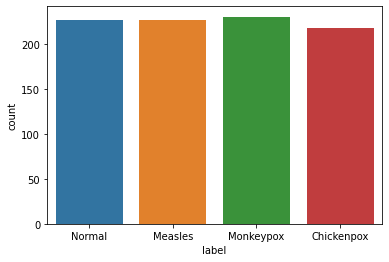

In [ ]:
ax = sns.countplot(x="label", data=df_train_val,)
plt.show()

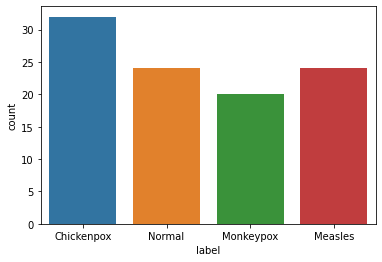

In [ ]:
ax = sns.countplot(x="label", data=df_test,)
plt.show()

#IMPORT MODEL

In [ ]:
model = keras.Sequential()

# Creating first block- (2 Convolution + 1 Max pool)
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), padding='same', input_shape= (224, 224, 3), activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating second block- (2 Convolution + 1 Max pool)
model.add(Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating third block- (3 Convolution + 1 Max pool)
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating fourth block- (3 Convolution + 1 Max pool)
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating fifth block- (3 Convolution + 1 Max pool)
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Flattening the pooled image pixels
model.add(Flatten())

# Creating 2 Dense Layers
model.add(Dense(units= 4096, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units= 4096, activation='relu'))
model.add(Dropout(rate=0.5))
# Creating an output layer
model.add(Dense(units= 4, activation='softmax'))

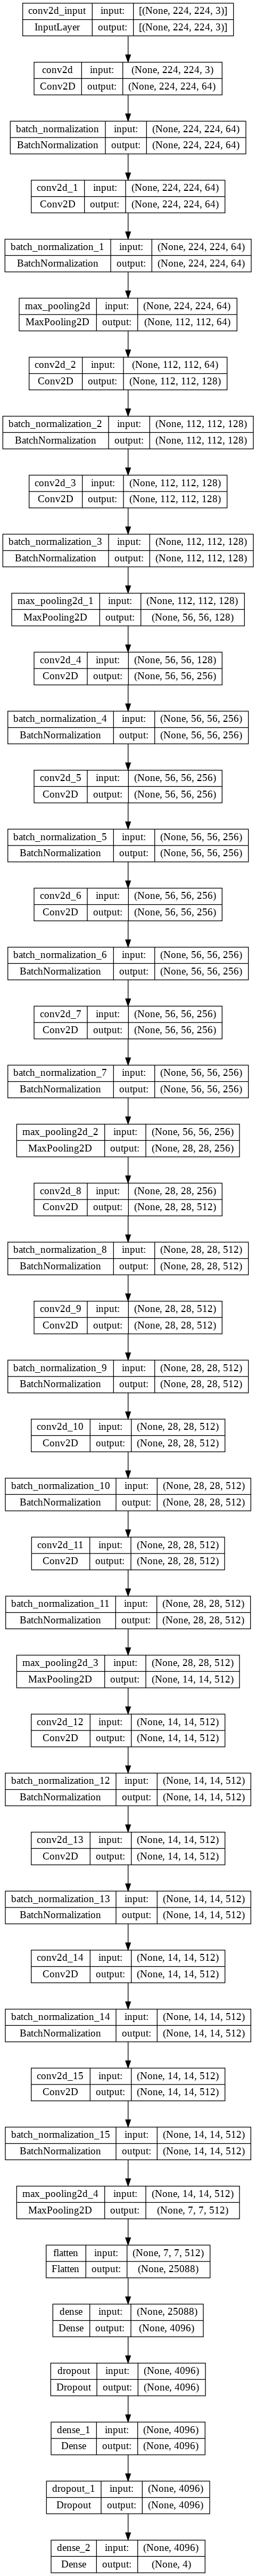

In [ ]:
plot_model(model = model, show_shapes = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

#PROSES AUGMENTASI

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,)
train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val, 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 

class_names = train_generator.class_indices
print(class_names)
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  # print(image_batch[0].shape)
  # zz.fit(image_batch)
  break

Found 900 validated image filenames belonging to 4 classes.
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}
(32, 224, 224, 3)
(32, 4)


#PELATIHAN MODEL

In [ ]:
def cross_validation_model_evaluate(model,  valData, i):
  val_datagen = ImageDataGenerator(rescale=1./255,)
  valData = df_train_val.iloc[val_index]
  val_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )

  Y_pred = model.predict(val_generator,)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test = val_generator.classes
  cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
  print(cm)
  eval_csv = '/content/drive/MyDrive/Luban_10Fold_90:10/' +"Model/" + '_fold_' + str(i) + '_model.log'
  eval_csv = pd.read_csv(eval_csv, )
  plt.plot(eval_csv['accuracy'])
  plt.plot(eval_csv['loss'])
  plt.plot(eval_csv['val_accuracy'])
  plt.plot(eval_csv['val_loss'])
  plt.title('model performance')
  plt.ylabel('accuracy / loss')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss'], loc='upper left')
  plt.show()
  eval_csv = eval_csv[(eval_csv.val_accuracy == eval_csv.val_accuracy.max())]
  eval_csv = eval_csv[(eval_csv.val_loss== eval_csv.val_loss.min())]
  print(eval_csv)

#PENGUJIAN MODEL USING K-CV

##SKENARIO 1

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 1:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 5.7980 - accuracy: 0.2988
Epoch 1: val_accuracy improved from -inf to 0.23333, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_1_model.h5
26/26 [==============================] - 302s 11s/step - loss: 5.7980 - accuracy: 0.2988 - val_loss: 1.5179 - val_accuracy: 0.2333
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 2.9907 - accuracy: 0.4111
Epoch 2: val_accuracy improved from 0.23333 to 0.25556, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_1_model.h5
26/26 [==============================] - 30s 1s/step - loss: 2.9907 - accuracy: 0.4111 - val_loss: 1.4343 - val_accuracy: 0.2556
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 2.4875 - accuracy: 0.4173
Epoch 3: val_accuracy di

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 251ms/step
Predict  0        1        2        3        
Actual
0        13       6        1        1        

1        6        14       3        0        

2        5        5        13       0        

3        3        1        1        18       





Overall Statistics : 

95% CI                                                            (0.54555,0.74334)
ACC Macro                                                         0.82222
ARI                                                               0.28827
AUNP                                                              0.76422
AUNU                                                              0.763
Bangdiwala B                                                      0.4256
Bennett S                                                         0.52593
CBA                                                               0.59194
CSI                  

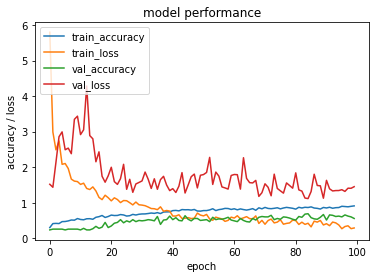

    epoch  accuracy      loss  val_accuracy  val_loss
84     84  0.864198  0.420768      0.688889   1.11544


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 1:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 2

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 2:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.6938
Epoch 1: val_accuracy improved from -inf to 0.64444, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_2_model.h5
26/26 [==============================] - 30s 1s/step - loss: 1.0207 - accuracy: 0.6938 - val_loss: 1.0947 - val_accuracy: 0.6444
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.9564 - accuracy: 0.6827
Epoch 2: val_accuracy did not improve from 0.64444
26/26 [==============================] - 25s 930ms/step - loss: 0.9564 - accuracy: 0.6827 - val_loss: 1.9242 - val_accuracy: 0.5667
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.7333
Epoch 3: val_accuracy improved from 0.64444 to 0.67778, saving model to /content/drive/MyDrive/Luban_10Fold_9

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 248ms/step
Predict  0        1        2        3        
Actual
0        17       1        2        1        

1        1        20       2        0        

2        1        0        22       0        

3        0        0        0        23       





Overall Statistics : 

95% CI                                                            (0.85232,0.96991)
ACC Macro                                                         0.95556
ARI                                                               0.77843
AUNP                                                              0.94073
AUNU                                                              0.93963
Bangdiwala B                                                      0.8376
Bennett S                                                         0.88148
CBA                                                               0.87089
CSI                

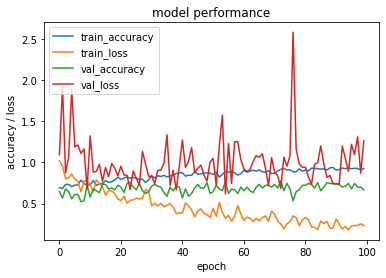

    epoch  accuracy      loss  val_accuracy  val_loss
72     72  0.917284  0.252825      0.777778   0.68414


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 2
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 2:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 3

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 3:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8667
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_3_model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.4615 - accuracy: 0.8667 - val_loss: 0.5187 - val_accuracy: 0.8333
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8704
Epoch 2: val_accuracy did not improve from 0.83333
26/26 [==============================] - 23s 892ms/step - loss: 0.3895 - accuracy: 0.8704 - val_loss: 0.6539 - val_accuracy: 0.7889
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.8728
Epoch 3: val_accuracy did not improve from 0.83333
26/26 [==============================] - 22s 813ms/step - 

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 244ms/step
Predict  0        1        2        3        
Actual
0        17       3        1        0        

1        0        23       0        0        

2        4        1        18       0        

3        1        1        0        21       





Overall Statistics : 

95% CI                                                            (0.81011,0.94545)
ACC Macro                                                         0.93889
ARI                                                               0.70472
AUNP                                                              0.91899
AUNU                                                              0.91789
Bangdiwala B                                                      0.78134
Bennett S                                                         0.83704
CBA                                                               0.82245
CSI               

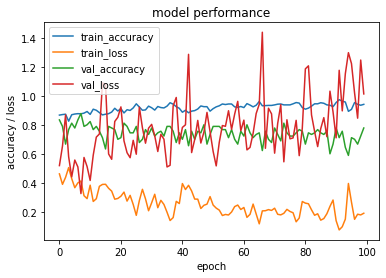

   epoch  accuracy      loss  val_accuracy  val_loss
7      7  0.875309  0.412422      0.877778  0.325873


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 3
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 3:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 4

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 4:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8704
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_4_model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.4725 - accuracy: 0.8704 - val_loss: 0.6160 - val_accuracy: 0.7778
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8753
Epoch 2: val_accuracy improved from 0.77778 to 0.93333, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_4_model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.3780 - accuracy: 0.8753 - val_loss: 0.2673 - val_accuracy: 0.9333
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.9000
Epoch 3: val_accuracy did 

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 239ms/step
Predict  0        1        2        3        
Actual
0        18       2        1        0        

1        3        18       2        0        

2        3        2        18       0        

3        0        2        1        20       





Overall Statistics : 

95% CI                                                            (0.74323,0.90121)
ACC Macro                                                         0.91111
ARI                                                               0.57585
AUNP                                                              0.88189
AUNU                                                              0.88196
Bangdiwala B                                                      0.67854
Bennett S                                                         0.76296
CBA                                                               0.78804
CSI               

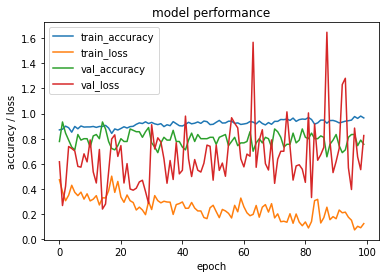

    epoch  accuracy      loss  val_accuracy  val_loss
14     14  0.897531  0.328991      0.933333  0.239289


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 4
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 4:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 5

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 5:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.8395
Epoch 1: val_accuracy improved from -inf to 0.84444, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_5_model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.5253 - accuracy: 0.8395 - val_loss: 0.4573 - val_accuracy: 0.8444
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8568
Epoch 2: val_accuracy did not improve from 0.84444
26/26 [==============================] - 22s 806ms/step - loss: 0.4607 - accuracy: 0.8568 - val_loss: 0.4697 - val_accuracy: 0.8444
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8728
Epoch 3: val_accuracy did not improve from 0.84444
26/26 [==============================] - 22s 828ms/step - 

###EVAL

Found 90 validated image filenames belonging to 4 classes.


3/3 [==============================] - 1s 241ms/step
Predict  0        1        2        3        
Actual
0        21       0        0        0        

1        4        19       0        0        

2        4        1        18       0        

3        0        1        0        22       





Overall Statistics : 

95% CI                                                            (0.82396,0.95382)
ACC Macro                                                         0.94444
ARI                                                               0.72056
AUNP                                                              0.9271
AUNU                                                              0.92743
Bangdiwala B                                                      0.8002
Bennett S                                                         0.85185
CBA                                                               0.82234
CSI                                                               0.79853
Chi-S

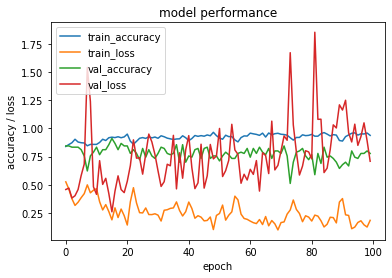

    epoch  accuracy     loss  val_accuracy  val_loss
15     15  0.922222  0.18786      0.911111  0.258889


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 5
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 5:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 6

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 6:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8864
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_6_model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3670 - accuracy: 0.8864 - val_loss: 0.2333 - val_accuracy: 0.9000
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.9185
Epoch 2: val_accuracy did not improve from 0.90000
26/26 [==============================] - 24s 898ms/step - loss: 0.3177 - accuracy: 0.9185 - val_loss: 0.2912 - val_accuracy: 0.9000
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.9049
Epoch 3: val_accuracy did not improve from 0.90000
26/26 [==============================] - 20s 755ms/step - 

###EVAL

Found 90 validated image filenames belonging to 4 classes.


3/3 [==============================] - 1s 228ms/step
Predict  0        1        2        3        
Actual
0        21       0        0        0        

1        2        20       1        0        

2        7        0        15       1        

3        1        0        0        22       





Overall Statistics : 

95% CI                                                            (0.79644,0.9369)
ACC Macro                                                         0.93333
ARI                                                               0.67924
AUNP                                                              0.91261
AUNU                                                              0.91294
Bangdiwala B                                                      0.77191
Bennett S                                                         0.82222
CBA                                                               0.78892
CSI                                                               0.76243
Chi-

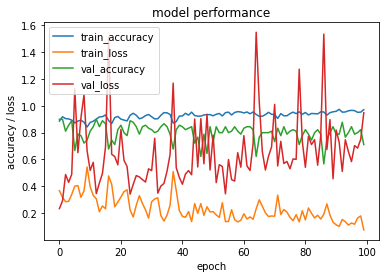

   epoch  accuracy      loss  val_accuracy  val_loss
0      0   0.88642  0.366969           0.9  0.233299


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 6
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 6:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 7

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 7:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8580
Epoch 1: val_accuracy improved from -inf to 0.74444, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_7_model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.4857 - accuracy: 0.8580 - val_loss: 0.8768 - val_accuracy: 0.7444
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8753
Epoch 2: val_accuracy did not improve from 0.74444
26/26 [==============================] - 23s 855ms/step - loss: 0.4288 - accuracy: 0.8753 - val_loss: 1.2561 - val_accuracy: 0.7333
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8914
Epoch 3: val_accuracy improved from 0.74444 to 0.83333, saving model to /content/drive/MyDrive/Luban_10Fold_9

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 240ms/step
Predict  0        1        2        3        
Actual
0        19       1        1        0        

1        1        22       0        0        

2        3        2        18       0        

3        0        0        0        23       





Overall Statistics : 

95% CI                                                            (0.85232,0.96991)
ACC Macro                                                         0.95556
ARI                                                               0.78143
AUNP                                                              0.94116
AUNU                                                              0.94078
Bangdiwala B                                                      0.83893
Bennett S                                                         0.88148
CBA                                                               0.87217
CSI               

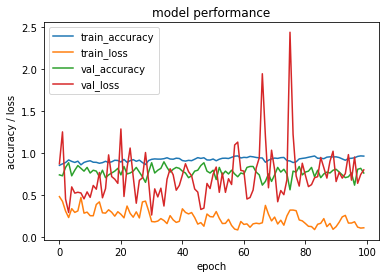

    epoch  accuracy      loss  val_accuracy  val_loss
34     34  0.937037  0.201293           0.9  0.373797


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 7
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 7:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 8

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 8:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.9148
Epoch 1: val_accuracy improved from -inf to 0.94444, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_8_model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.3120 - accuracy: 0.9148 - val_loss: 0.2061 - val_accuracy: 0.9444
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8988
Epoch 2: val_accuracy did not improve from 0.94444
26/26 [==============================] - 22s 852ms/step - loss: 0.3508 - accuracy: 0.8988 - val_loss: 0.2085 - val_accuracy: 0.9222
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.9062
Epoch 3: val_accuracy did not improve from 0.94444
26/26 [==============================] - 21s 812ms/step - 

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 243ms/step
Predict  0        1        2        3        
Actual
0        21       0        0        0        

1        0        23       0        0        

2        1        0        22       0        

3        0        0        0        23       





Overall Statistics : 

95% CI                                                            (0.96723,1.01055)
ACC Macro                                                         0.99444
ARI                                                               0.97072
AUNP                                                              0.99275
AUNU                                                              0.99275
Bangdiwala B                                                      0.97878
Bennett S                                                         0.98519
CBA                                                               0.97777
CSI               

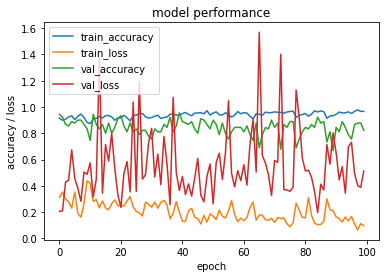

    epoch  accuracy      loss  val_accuracy  val_loss
39     39  0.937037  0.199894      0.955556  0.364996


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 8
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 8:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 9

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 9:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.9321
Epoch 1: val_accuracy improved from -inf to 0.78889, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_9_model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.2545 - accuracy: 0.9321 - val_loss: 0.8627 - val_accuracy: 0.7889
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9272
Epoch 2: val_accuracy improved from 0.78889 to 0.84444, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_9_model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.2753 - accuracy: 0.9272 - val_loss: 0.4199 - val_accuracy: 0.8444
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9284
Epoch 3: val_accuracy impr

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 1s 246ms/step
Predict  0        1        2        3        
Actual
0        20       1        0        0        

1        0        23       0        0        

2        4        1        18       0        

3        1        0        0        22       





Overall Statistics : 

95% CI                                                            (0.86689,0.97755)
ACC Macro                                                         0.96111
ARI                                                               0.80567
AUNP                                                              0.94884
AUNU                                                              0.94865
Bangdiwala B                                                      0.8599
Bennett S                                                         0.8963
CBA                                                               0.86478
CSI                 

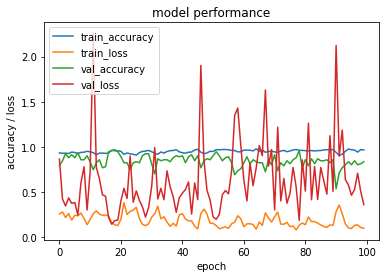

    epoch  accuracy      loss  val_accuracy  val_loss
18     18  0.955556  0.134357      0.966667   0.17992


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 9
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 9:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 10

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 10:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (810, 2)
val shape: (90, 2)
Found 810 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9247
Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to /content/drive/MyDrive/Luban_10Fold_90:10/Model/_fold_10_model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.2507 - accuracy: 0.9247 - val_loss: 0.4590 - val_accuracy: 0.8889
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.9136
Epoch 2: val_accuracy did not improve from 0.88889
26/26 [==============================] - 23s 847ms/step - loss: 0.3153 - accuracy: 0.9136 - val_loss: 0.4033 - val_accuracy: 0.8667
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9543
Epoch 3: val_accuracy improved from 0.88889 to 0.94444, saving model to /content/drive/MyDrive/Luban_10Fold_

###EVAL

Found 90 validated image filenames belonging to 4 classes.
3/3 [==============================] - 57s 18s/step
Predict  0        1        2        3        
Actual
0        20       0        1        0        

1        1        22       0        0        

2        1        0        22       0        

3        0        0        0        23       





Overall Statistics : 

95% CI                                                            (0.92958,1.00375)
ACC Macro                                                         0.98333
ARI                                                               0.91352
AUNP                                                              0.97804
AUNU                                                              0.97769
Bangdiwala B                                                      0.93633
Bennett S                                                         0.95556
CBA                                                               0.95553
CSI                

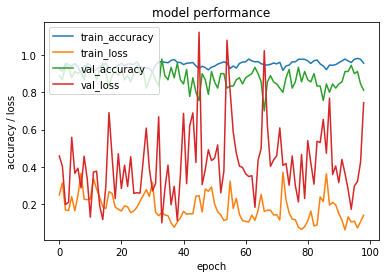

    epoch  accuracy      loss  val_accuracy  val_loss
33     33  0.964198  0.155571      0.977778  0.101005


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 10
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 10:
    model_filepath = '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

#HASIL SELURUH SKENARIO K_FOLD

In [ ]:
df_result_experiment = pd.DataFrame()
for i in range(1, 11):
  df_result = pd.read_csv('/content/drive/MyDrive/Luban_10Fold_90:10/' +"Model/" + '_fold_' + str(i) + '_model.log')
  df_result = df_result[(df_result.val_accuracy == df_result.val_accuracy.max())]
  df_result = df_result[(df_result.val_loss== df_result.val_loss.min())]
  df_result_experiment = pd.concat([df_result_experiment, df_result])


df_result_experiment = df_result_experiment.reset_index(drop=True)
df_result_experiment.index += 1
pd.set_option('display.max_rows', df_result_experiment.shape[0]+1)
df_average =df_result_experiment.iloc[:].mean(axis=0)
df_result_experiment.loc[11] = df_average
df_result_experiment = df_result_experiment.style.background_gradient(cmap='Accent', subset=df_result_experiment.index[-1])
df_result_experiment

,epoch,accuracy,loss,val_accuracy,val_loss
1,84.000000,0.864198,0.420768,0.688889,1.115440
2,72.000000,0.917284,0.252825,0.777778,0.684140
3,7.000000,0.875309,0.412422,0.877778,0.325873
4,14.000000,0.897531,0.328991,0.933333,0.239289
5,15.000000,0.922222,0.187860,0.911111,0.258889
6,0.000000,0.886420,0.366969,0.900000,0.233299
7,34.000000,0.937037,0.201293,0.900000,0.373797
8,39.000000,0.937037,0.199894,0.955556,0.364996
9,18.000000,0.955556,0.134357,0.966667,0.179920
10,33.000000,0.964198,0.155571,0.977778,0.101005


#PENGUJIAN USING UNSEEN DATA

##SKEN 1

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '1' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 63s 14s/step
Predict  0        1        2        3        
Actual
0        21       5        2        4        

1        5        14       2        3        

2        7        4        9        0        

3        3        1        3        17       





Overall Statistics : 

95% CI                                                            (0.5144,0.7056)
ACC Macro                                                         0.805
ARI                                                               0.22382
AUNP                                                              0.73411
AUNU                                                              0.73327
Bangdiwala B                                                      0.38377
Bennett S                                                         0.48
CBA                                                               0.58125
CSI                      

##SKEN 2

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '2' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 63s 14s/step
Predict  0        1        2        3        
Actual
0        18       8        3        3        

1        5        16       2        1        

2        0        4        15       1        

3        0        0        1        23       





Overall Statistics : 

95% CI                                                            (0.632,0.808)
ACC Macro                                                         0.86
ARI                                                               0.40831
AUNP                                                              0.81389
AUNU                                                              0.82066
Bangdiwala B                                                      0.5336
Bennett S                                                         0.62667
CBA                                                               0.66741
CSI                       

##SKEN 3

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '3' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 66s 14s/step
Predict  0        1        2        3        
Actual
0        24       6        0        2        

1        6        17       0        1        

2        5        2        13       0        

3        7        0        0        17       





Overall Statistics : 

95% CI                                                            (0.62106,0.79894)
ACC Macro                                                         0.855
ARI                                                               0.33972
AUNP                                                              0.79528
AUNU                                                              0.8009
Bangdiwala B                                                      0.49292
Bennett S                                                         0.61333
CBA                                                               0.65244
CSI                  

##SKEN 4

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '4' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 68s 15s/step
Predict  0        1        2        3        
Actual
0        19       7        2        4        

1        5        15       2        2        

2        6        4        8        2        

3        4        0        1        19       





Overall Statistics : 

95% CI                                                            (0.5144,0.7056)
ACC Macro                                                         0.805
ARI                                                               0.22595
AUNP                                                              0.73346
AUNU                                                              0.73467
Bangdiwala B                                                      0.38588
Bennett S                                                         0.48
CBA                                                               0.55986
CSI                      

##SKEN 5

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '5' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 65s 14s/step
Predict  0        1        2        3        
Actual
0        27       0        0        5        

1        7        15       2        0        

2        4        3        10       3        

3        2        1        0        21       





Overall Statistics : 

95% CI                                                            (0.64298,0.81702)
ACC Macro                                                         0.865
ARI                                                               0.41053
AUNP                                                              0.81296
AUNU                                                              0.80871
Bangdiwala B                                                      0.55951
Bennett S                                                         0.64
CBA                                                               0.63103
CSI                    

##SKEN 6

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '6' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 62s 14s/step
Predict  0        1        2        3        
Actual
0        24       2        0        6        

1        8        13       2        1        

2        6        1        13       0        

3        3        0        0        21       





Overall Statistics : 

95% CI                                                            (0.62106,0.79894)
ACC Macro                                                         0.855
ARI                                                               0.3582
AUNP                                                              0.79671
AUNU                                                              0.80126
Bangdiwala B                                                      0.50787
Bennett S                                                         0.61333
CBA                                                               0.63176
CSI                  

##SKEN 7

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '7' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 62s 14s/step
Predict  0        1        2        3        
Actual
0        26       2        1        3        

1        8        16       0        0        

2        4        2        13       1        

3        3        0        0        21       





Overall Statistics : 

95% CI                                                            (0.67629,0.84371)
ACC Macro                                                         0.88
ARI                                                               0.43814
AUNP                                                              0.83082
AUNU                                                              0.83323
Bangdiwala B                                                      0.5771
Bennett S                                                         0.68
CBA                                                               0.6977
CSI                       

##SKEN 8

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '8' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 65s 14s/step
Predict  0        1        2        3        
Actual
0        23       3        1        5        

1        4        17       2        1        

2        2        3        13       2        

3        1        0        1        22       





Overall Statistics : 

95% CI                                                            (0.66513,0.83487)
ACC Macro                                                         0.875
ARI                                                               0.43714
AUNP                                                              0.83142
AUNU                                                              0.83207
Bangdiwala B                                                      0.57193
Bennett S                                                         0.66667
CBA                                                               0.7026
CSI                  

##SKEN 9

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '9' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 85s 20s/step
Predict  0        1        2        3        
Actual
0        27       2        0        3        

1        9        13       1        1        

2        5        4        10       1        

3        4        1        0        19       





Overall Statistics : 

95% CI                                                            (0.59935,0.78065)
ACC Macro                                                         0.845
ARI                                                               0.33022
AUNP                                                              0.78245
AUNU                                                              0.78025
Bangdiwala B                                                      0.50037
Bennett S                                                         0.58667
CBA                                                               0.60833
CSI                 

##SKEN 10

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '10' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 100 validated image filenames belonging to 4 classes.
4/4 [==============================] - 73s 17s/step
Predict  0        1        2        3        
Actual
0        22       3        1        6        

1        6        11       3        4        

2        3        2        13       2        

3        1        0        1        22       





Overall Statistics : 

95% CI                                                            (0.58857,0.77143)
ACC Macro                                                         0.84
ARI                                                               0.32518
AUNP                                                              0.78338
AUNU                                                              0.78491
Bangdiwala B                                                      0.48684
Bennett S                                                         0.57333
CBA                                                               0.61072
CSI                  

#UJI COBA KLASIFIKASI 1

1/1 [==============================] - 1s 1s/step
prediction is Monkeypox


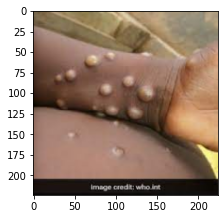

In [ ]:
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '7' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/Luban_10Fold_90:10/Dataset/Monkeypox/monkeypox (49).jpg')

#UJI COBA KLASIFIKASI 2

1/1 [==============================] - 1s 1s/step
prediction is Chickenpox


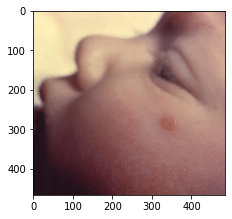

In [ ]:
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '7' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/Luban_10Fold_90:10/Dataset/Chickenpox/chickenpox (321).jpg')

#UJI COBA KLASIfIKASI 3

1/1 [==============================] - 2s 2s/step
prediction is Measles


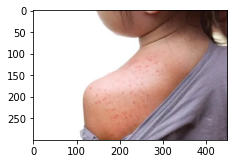

In [ ]:
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '7' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/Luban_10Fold_90:10/Dataset/Measles/measles (166).jpg')

#UJI COBA KLASIFIKASI 4

1/1 [==============================] - 1s 1s/step
prediction is Normal


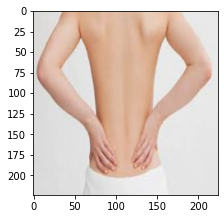

In [ ]:
model_filepath =  '/content/drive/MyDrive/Luban_10Fold_90:10/' + "Model/" + '_fold_' + '7' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/Luban_10Fold_90:10/Dataset/Normal/normal (194).jpg')